In [456]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as plt 
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4
import tensorflow as tf
import re
from matplotlib.ticker import PercentFormatter



In [457]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [458]:
dateparse = lambda x: pd.datetime.strptime(x, '%d/%M/%Y')
df = pd.read_csv('/content/drive/My Drive/redes_neurais/Manaus.csv', sep=';', header=0, encoding='iso-8859-1')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15,21,23,29,30,31,32,34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


2.1.1 -Quantos atributos descrevem cada exemplo? Quais são eles?

In [459]:
df.head()

,_idade,_faixa etária,_sexo,_bairro,_classificacao,_comorb_renal,_comorb_diabetes,_comorb_imuno,_comorb_cardio,_conclusao,_dt_notificacao,_taxa,_dt_evolucao,_raca,_dt_sintomas,_criterio,_sintoma_garganta,_sintoma_dispneia,_sintoma_febre,_sintoma_tosse,_sintoma_outros,_etnia,_profiss_saude,_srag,_se_notificacao,_distrito,_bairro_mapa,_comorb_respiratoria,_comorb_cromossomica,_comorb_hepatica,_comorb_neurologica,_comorb_hemato,_comorb_obessidade,_origem,_evolução,_teste_pcr,_teste_anticorpo,_teste_antigeno,_teste_igm,_teste_igg
0,31.0,30a - 39a,F,JAPIIM,Confirmado,Não,Não,Não,Não,NaN,04/05/2020,"0,173837462",NaN,NaN,24/04/2020,NaN,Não,Não,Sim,Não,Não,NaN,Não,NaN,19.0,SUL,JAPIIM,Não,Não,NaN,NaN,NaN,NaN,"eSUS VE,",NaN,1.0,0.0,0.0,0.0,0.0
1,40.0,40a - 49a,F,LAGO AZUL,Confirmado,Não,Não,Não,Não,NaN,04/05/2020,"0,178428049",NaN,NaN,24/04/2020,NaN,Não,Não,Sim,Não,Não,NaN,Não,NaN,19.0,NORTE,LAGO AZUL,Não,Não,NaN,NaN,NaN,NaN,"eSUS VE,",NaN,1.0,0.0,0.0,0.0,0.0
2,36.0,30a - 39a,M,BETANIA,Confirmado,Não,Não,Não,Não,NaN,04/05/2020,"0,801603206",NaN,NaN,24/04/2020,NaN,Não,Não,Sim,Não,Não,NaN,Não,NaN,19.0,SUL,BETÂNIA,Não,Não,NaN,NaN,NaN,NaN,"eSUS VE,",NaN,1.0,0.0,0.0,0.0,0.0
3,43.0,40a - 49a,F,SANTA ETELVINA,Em análise,Não,Não,Não,Não,Recuperado,08/04/2020,"0,314386318",NaN,Parda,24/03/2020,NaN,Sim,Não,Sim,Sim,Sim,NaN,Não,NaN,15.0,NORTE,SANTA ETELVINA,Não,Não,NaN,NaN,NaN,NaN,"eSUS VE,",NaN,0.0,0.0,0.0,0.0,0.0
4,26.0,20a - 29a,F,FLORES,Confirmado,Não,Não,Não,Não,NaN,01/06/2020,"0,198306463",NaN,NaN,24/04/2020,NaN,Não,Não,Sim,Não,Não,NaN,Não,NaN,23.0,SUL,FLORES,Não,Não,NaN,NaN,NaN,NaN,"eSUS VE,",NaN,1.0,1.0,0.0,0.0,0.0


In [460]:
print('Número de atributos: ', len(df.columns) )
print('Atributos que descrevem cada exemplo: ', df.columns.values)


Número de atributos:  40
Atributos que descrevem cada exemplo:  ['_idade' '_faixa etária' '_sexo' '_bairro' '_classificacao'
 '_comorb_renal' '_comorb_diabetes' '_comorb_imuno' '_comorb_cardio'
 '_conclusao' '_dt_notificacao' '_taxa' '_dt_evolucao' '_raca'
 '_dt_sintomas' '_criterio' '_sintoma_garganta' '_sintoma_dispneia'
 '_sintoma_febre' '_sintoma_tosse' '_sintoma_outros' '_etnia'
 '_profiss_saude' '_srag' '_se_notificacao' '_distrito' '_bairro_mapa'
 '_comorb_respiratoria' '_comorb_cromossomica' '_comorb_hepatica'
 '_comorb_neurologica' '_comorb_hemato' '_comorb_obessidade' '_origem'
 '_evolução' '_teste_pcr' '_teste_anticorpo' '_teste_antigeno'
 '_teste_igm' '_teste_igg']


2.1.2 - Quantos casos confirmados há em Manaus, cumulativamente?

In [461]:
df = df[df._classificacao == 'Confirmado']
casos_confirmados = len(df)

In [462]:
print('Número de casos confirmados acumulados', casos_confirmados)  

Número de casos confirmados acumulados 39037


2.1.3 - A qual período de tempo a base de dados se refere, isto é, qual o registro mais antigo e qual o
mais recente? Leve em conta a data de notificação.

In [463]:
df = df.dropna(subset = ['_dt_notificacao'])
df['_dt_notificacao'] = pd.to_datetime(df['_dt_notificacao'], format="%d/%m/%Y")
antigo = df['_dt_notificacao'].min()
recente = df['_dt_notificacao'].max()
print('O período mais antigo levando-se em conta as notificações: ', antigo)
print('O período mais recente levando-se em conta as notificações: ', recente)


O período mais antigo levando-se em conta as notificações:  2020-02-16 00:00:00
O período mais recente levando-se em conta as notificações:  2020-08-14 00:00:00


Para fins da análise considerada no escopo deste projeto, vamos excluir todos os atributos relativos
às **comorbidades**, **sintomas**, **etnia**, **profissão**, outras **datas que não a de notificação**, **origem** e outros
que não estiverem envolvidos no contexto do trabalho solicitado. Estes atributos serão considerados
irrelevantes para fins de simplificação.** Exclua** todas as **linhas** em que houver **dados faltantes** para os
**atributos remanescentes**.

In [464]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38913 entries, 0 to 115869
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   _idade                38859 non-null  float64       
 1   _faixa etária         38913 non-null  object        
 2   _sexo                 38746 non-null  object        
 3   _bairro               38351 non-null  object        
 4   _classificacao        38913 non-null  object        
 5   _comorb_renal         33700 non-null  object        
 6   _comorb_diabetes      34124 non-null  object        
 7   _comorb_imuno         33622 non-null  object        
 8   _comorb_cardio        34163 non-null  object        
 9   _conclusao            14602 non-null  object        
 10  _dt_notificacao       38913 non-null  datetime64[ns]
 11  _taxa                 37031 non-null  object        
 12  _dt_evolucao          17686 non-null  object        
 13  _raca          

2.2.1. Quantos exemplos e atributos há na base de dados após a limpeza e organização?

In [465]:
df = df[df.columns.drop(list(df.filter(regex='_sint*|_comorb*|_etnia|_profiss*|_faixa.etária|_dt_evolucao|_origem|_taxa|_raca|_dt_sintomas|_etnia|_srag|_se_notificacao|_distrito|_evolução|_criterio')))].dropna()
exemplos = len(df)
atributos = len(df.columns)
print('Numero de exemplos: ', exemplos)
print('Numero de Atributos', atributos)

Numero de exemplos:  8369
Numero de Atributos 12


2.2.2. Qual a porcentagem de indivíduos recuperados em relação ao todo?

In [466]:
recuperados = df['_conclusao'].value_counts(normalize=True)*100
print('Porcentagem de recuperados = ', recuperados[0] )

Porcentagem de recuperados =  94.71860437328236


2.2.3 -Os casos acometeram mais indivíduos do sexo masculino ou feminino?

In [467]:
sexo = df['_sexo'].value_counts(normalize=True)*100
print('Os casos acometem mais homens =  ', sexo[0])

Os casos acometem mais homens =   54.52264308758513


2.2.4 - Qual a média e desvio padrão de idade dos indivíduos que contraíram COVID-19? Qual o
indivíduo mais jovem e o mais idoso a contraírem tal enfermidade?

In [468]:
media = df['_idade'].mean()
desvio = df['_idade'].std()
print('A média de idade de indivíduos que contraíram covid 19: ', media)
print('O desvio padrão da idade de indivíduos que contraíram covid 19: ', desvio)

A média de idade de indivíduos que contraíram covid 19:  42.84335046003107
O desvio padrão da idade de indivíduos que contraíram covid 19:  15.45048385316694


2.2.5 - Qual o bairro com maior incidência de casos?

In [471]:
bairros = df.groupby('_bairro_mapa')['_bairro_mapa'].count().sort_values().tail(1)
print('O bairro de maior incidência :', bairros)

O bairro de maior incidência : _bairro_mapa
CIDADE NOVA    564
Name: _bairro_mapa, dtype: int64


2.2.6 - Quais os três bairros com maior incidência de casos recuperados?

In [479]:
df.loc[df['_conclusao'] == 'Recuperado'].groupby('_bairro_mapa')['_bairro_mapa'].count().sort_values().tail(3)

_bairro_mapa
FLORES               348
SÃO JOSÉ OPERÁRIO    356
CIDADE NOVA          541
Name: _bairro_mapa, dtype: int64

2.2.7 - Quais os tipos de testes efetuados, segundo os dados? Indique os dados de maneira quantitativa
e percentual.

In [480]:
print('Testes realizados em porcentagem:\n', df.filter(regex='_test*').mean()*100)
print('\nTestes realizados quantitativamente:\n', df.filter(regex='_test*').sum())

Testes realizados em porcentagem:
 _teste_pcr          60.783845
_teste_anticorpo    66.758275
_teste_antigeno     19.118174
_teste_igm           0.513801
_teste_igg           0.071693
dtype: float64

Testes realizados quantitativamente:
 _teste_pcr          5087.0
_teste_anticorpo    5587.0
_teste_antigeno     1600.0
_teste_igm            43.0
_teste_igg             6.0
dtype: float64


2.2.8 - Qual taxa de letalidade pode ser calculada a partir do conjunto de dados? Para calcular esta
taxa, considere a fração do total de óbitos pelo total de casos;

In [481]:
print('A taxa de letalidade é: ',df['_conclusao'].value_counts()[1]/df['_conclusao'].count())

A taxa de letalidade é:  0.052813956267176485


2.2.9 - Qual o tipo de correlação, mediante coeficiente de correlação de Pearson, entre a idade e o
número de casos? Para responder a esta pergunte, agrupe o número de casos por idade e efetue
o cálculo de tal coeficiente. Indique, a partir do resultado, a natureza desta correlação, se é
positiva ou negativa, e qual sua intensidade.

In [482]:
frame = df['_idade'].value_counts().rename_axis('unique_values').reset_index(name='counts')
pearson = frame['unique_values'].corr(frame['counts'])
print('Existe uma correlação positiva desprezível:', pearson)

Existe uma correlação positiva desprezível: -0.21838340431215794


2.3.1 - Construa um histograma denotando a quantidade de casos nos 10 bairros em que houve mais casos registrados. Inclua todos os bairros remanescentes em uma categoria denominada "Outros." Denote as informações de maneira percentual;

No handles with labels found to put in legend.


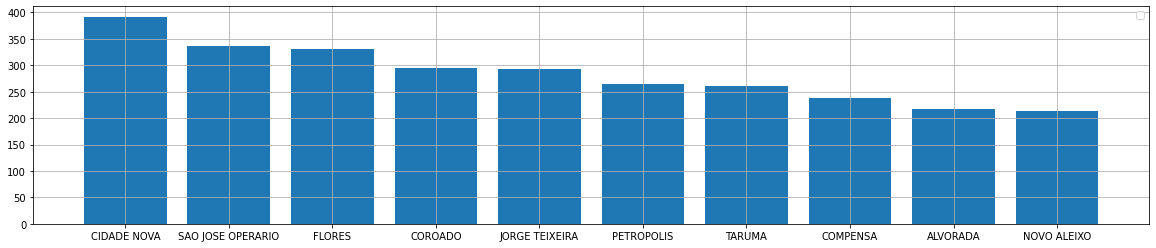

In [483]:
#plt.bar(range(len(df)), df.values, align='center')
df_bairros = df['_bairro'].value_counts().head(10).rename_axis('unique_values').reset_index(name='counts')
plt.bar(df_bairros['unique_values'], df_bairros['counts'] )
plt.grid()
plt.legend()



2.3.2 - Denote, por sexo, o boxplot da idade dos casos confirmados. Há outliers?

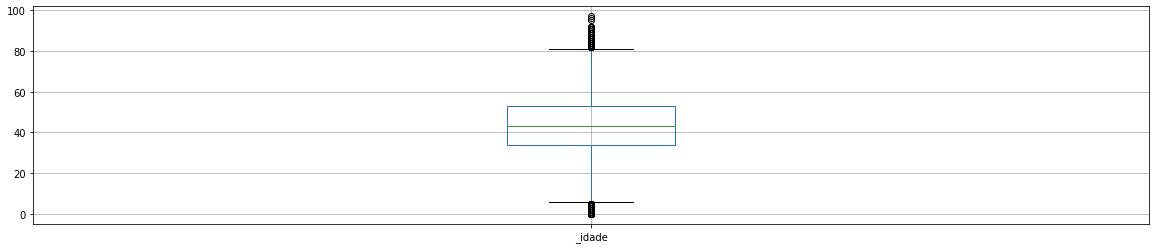

In [484]:
masculino =  df[df['_sexo'] == 'M' ]
masculino.boxplot('_idade')

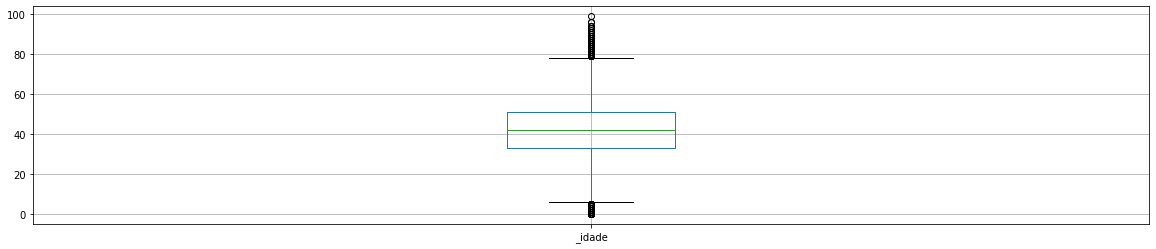

In [485]:
masculino =  df[df['_sexo'] == 'F' ]
masculino.boxplot('_idade')

2.3.4 - Denote em um gráfico de barras o número de novos casos por dia, considerando os 10 últimos
dias existentes na base de dados;

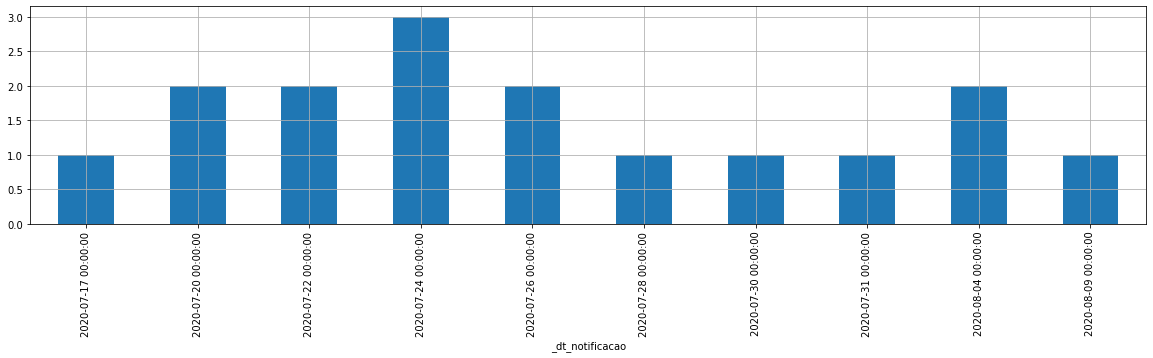

In [486]:
df.groupby('_dt_notificacao')['_dt_notificacao'].count().tail(10).plot(kind='bar', grid=True)

2.3.5 - Repita o gráfico anterior considerando o número de casos recuperado:

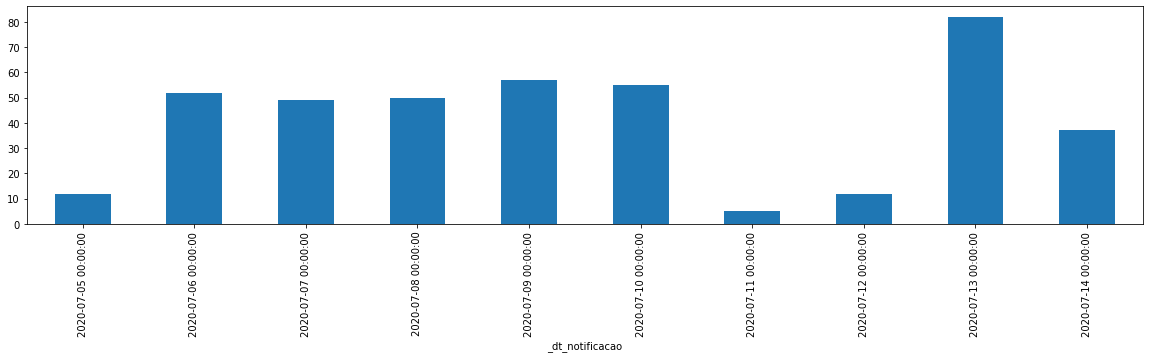

In [487]:
df[df['_conclusao'] == 'Recuperado'].groupby('_dt_notificacao')['_dt_notificacao'].count().tail(10).plot(kind='bar')

2.3.6 - Construa um histograma que denote a quantidade percentual de casos por grupo etário, considerando que cada grupo contempla uma década (0 a 10 anos, 11 a 20 anos, etc.);

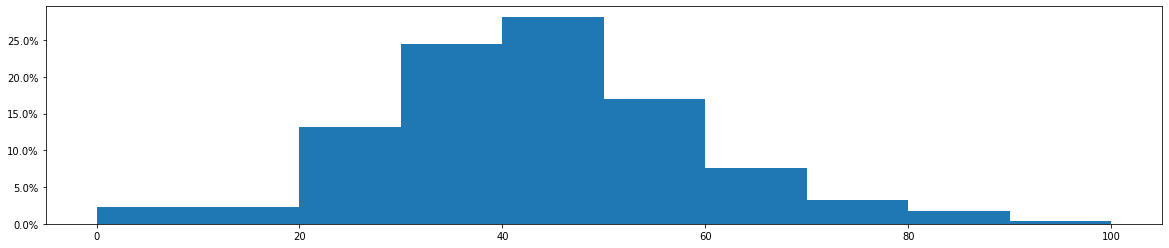

In [488]:
plt.hist(df['_idade'],bins=[0,10,20,30,40,50,60,70,80,90,100], weights=np.ones(len(df)) / len(df))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

2.3.7 - Elabore um gráfico que mostra o cumulativo de casos notificados ao longo do tempo;

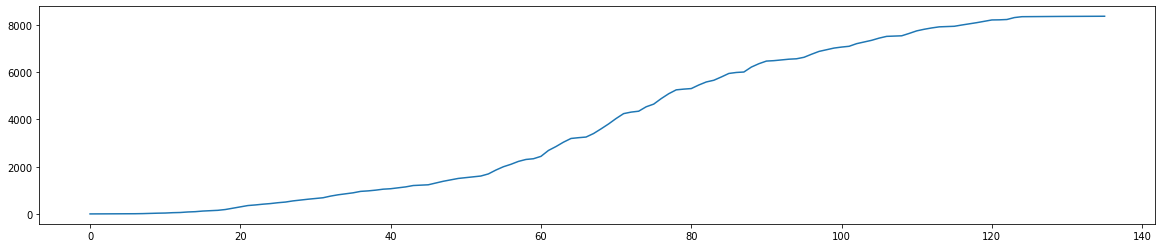

In [489]:
df_agrupados = df.groupby('_dt_notificacao')['_dt_notificacao'].count().cumsum().rename_axis('unique_values').reset_index(name='counts')
plt.plot(df_agrupados['counts'])


2.3.8 - Faça um gráfico do tipo scatterplot que denote a idade versus o número total de casos registrado
para aquela idade. Aproveite o processamento efetuado para o cálculo da correlação. É possível
observar alguma tendência?

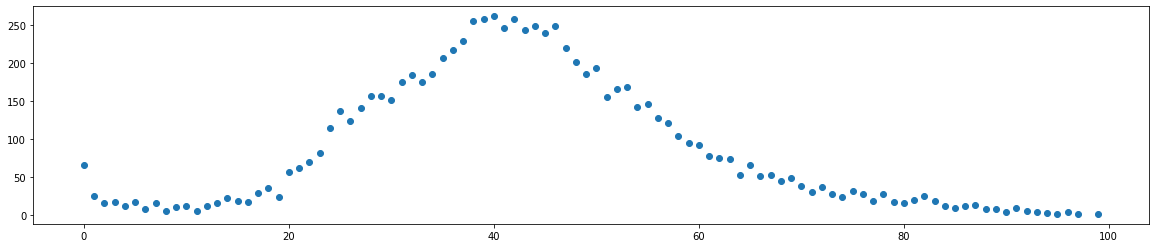

In [490]:
df_agrupamento = df.groupby('_idade')['_idade'].count().rename_axis('unique_values').reset_index(name='counts')
plt.scatter(df_agrupamento['unique_values'], df_agrupamento['counts'] )